In [1]:
# General imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import random
import sys, gc, time
import os

# data
import datetime
import itertools
import json
import pickle

# sklearn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler #StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# keras
# from keras_models import create_model17EN1EN2emb1, create_model17noEN1EN2, create_model17

# model
import lightgbm as lgb
from bayes_opt import BayesianOptimization

# custom modules
# from engine.features_yj import Features
from preprocess import load_df_added, drop_useless, check_na, run_label_all, remove_outliers, run_stdscale

In [9]:
#local_DIR = os.getcwd()
featured_DATA_DIR = '../data/20'
# PROCESSED_DATA_DIR = local_DIR +'/data/21'

df_wd_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wd_lag.pkl')
df_wd_no_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wd_no_lag.pkl')
df_wk_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_lag.pkl')
df_wk_no_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_no_lag.pkl')
#df_all_lag = pd.read_pickle(featured_DATA_DIR + '/train_fin_light_ver.pkl')
#df_all = pd.read_pickle(featured_DATA_DIR + '/train_fin_wk_lag.pkl')

In [10]:
## drop unnecessary lag columns
df_wd_lag = df_wd_lag.drop(columns = ['lag_sales_wk_1','lag_sales_wk_2'])
df_wk_lag = df_wk_lag.drop(columns = ['lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3', 'lag_sales_wd_4', 'lag_sales_wd_5'])


In [11]:
lag_col1 = ['lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',
            'lag_bigcat_price_day','lag_bigcat_count_day','lag_small_c_price','lag_small_c_count']

lag_col2 = ['rolling_mean_7', 'rolling_mean_14', 'lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3',
            'lag_sales_wd_4', 'lag_sales_wd_5', 'lag_sales_wk_1','lag_sales_wk_2', 'ts_pred',
           'rolling_mean_mcode_7','rolling_mean_mcode_14',]

cat_col = ['상품군','weekdays','show_id','small_c','middle_c','big_c',
                        'pay','months','hours_inweek','weekends','japp','parttime',
                        'min_start','primetime','prime_origin','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter','rain']

In [13]:
check_na(df_wk_lag.iloc[:,40:])

lag_mcode_count          2165
lag_bigcat_price            0
lag_bigcat_count            0
lag_bigcat_price_day     1034
lag_bigcat_count_day     1034
lag_small_c_price         897
lag_small_c_count         897
lag_all_price_show          0
lag_all_price_day           0
bpower                      0
steady                      0
men                         0
luxury                      0
pay                         0
spring                      0
summer                      0
fall                        0
winter                      0
small_click_r               0
mid_click_r                10
big_click_r                 0
rain                        0
temp_diff_s                 0
exposed_t                   0
age30_small                 0
age40_small                 0
age50_small                 0
age60above_small            0
age30_middle                9
age40_middle                9
age50_middle                9
age60above_middle           9
age30_big                   0
age40_big 

In [16]:
## simple function that will be used for run_preprocess
def na_to_zeroes(df):
    """
    :objective: Change all na's to zero.(just for original lag!)
    :return: pandas dataframe
    """
    xcol = [x for x in df.columns if x in lag_col1+lag_col2]
    for col in xcol:
        df[col] = df[col].fillna(0)

    return df

def drop_cat(df_pca):
    """
    :objective: Before PCA, drop categorical variables
    :return: pandas dataframe
    """
    xcol = [x for x in df_pca.columns if x in cat_col+lag_col2]
    df_pca = df_pca.drop(columns = xcol)
    df_pca = df_pca.drop(columns = '취급액')

    return df_pca

def run_pca(df_pca_scaled, n_components = 5):
    """
    :objective: Run PCA with n_components = 5
    :return: pandas dataframe
    """
    pca = PCA(n_components = 5)
    pca.fit(df_pca_scaled)
    df_pca = pca.transform(df_pca_scaled)

    return df_pca

## run preprocessing in a shot
## pca is optional and only applied to numeric features other than 'lag'
## NOTICE: removing outliers were run prior to dividing train/val
## if replace = True, new PCA will replace corresponding numerical columns
## if you want to simply add PCA columns to original data, set replace = False
def run_preprocess(df, pca = True, replace = True):
    """
    :objective: Run Feature deletion, NA imputation, label encoding, pca(optional)
    :return: pandas dataframe
    """
    df = drop_useless(df)
    df = na_to_zeroes(df)
    df = remove_outliers(df)
    df = run_label_all(df)
    df1 = df.copy()
    if pca:
        xcol = [x for x in df1.columns if x in cat_col+lag_col2]
        df_pca = df1.copy()
        df_pca = drop_cat(df_pca).copy()
        df_pca = run_stdscale(df_pca)
        df_pca = run_pca(df_pca)
        if replace:
            df_pca1 = pd.concat([df1[xcol], pd.DataFrame(df_pca)], axis=1)
            return df_pca1
        else:
            df_pca2 = pd.concat([df1, pd.DataFrame(df_pca)], axis=1)
            return df_pca2
    else:
        return df1


In [17]:
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
df_wd_lag_PP = run_preprocess(df_wd_lag, pca = True, replace = False)
df_wd_no_lag_PP = run_preprocess(df_wd_no_lag, pca = True, replace =False)
#df_wk_lag_PP = run_preprocess(df_wk_lag, pca = True, replace = False)
#df_wk_no_lag_PP = run_preprocess(df_wk_no_lag, pca = True, replace = False)

# Weekday

# Data Types

## 1. All + PCA

In [21]:
train1_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액'])
train1_y = df_wd_lag_PP.iloc[:16904,3]
val1_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액'])
val1_y = df_wd_lag_PP.iloc[16904:,3]

## 2. All /  No PCA

In [22]:
train2_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액',0,1,2,3,4])
train2_y = df_wd_lag_PP.iloc[:16904,3]
val2_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액',0,1,2,3,4])
val2_y = df_wd_lag_PP.iloc[16904:,3]

## 3. Just Lags

In [23]:
xcol = [x for x in df_wd_lag_PP.columns if x in lag_col1+lag_col2]
train3_x = df_wd_lag_PP[xcol+['판매단가','상품군']].iloc[:16904,:]
train3_y = df_wd_lag_PP.iloc[:16904,3]
val3_x = df_wd_lag_PP[xcol+['판매단가','상품군']].iloc[16904:,:]
val3_y = df_wd_lag_PP.iloc[16904:,3]

## 4. No Lags / No PCA

In [24]:
train4_x = df_wd_no_lag_PP.drop(columns = ['index','show_id','취급액']).iloc[:16904,:]
train4_y = df_wd_no_lag_PP.iloc[:16904,3]
val4_x = df_wd_no_lag_PP.drop(columns = ['index','show_id','취급액']).iloc[16904:,:]
val4_y = df_wd_no_lag_PP.iloc[16904:,3]

## 5. No categorical

In [25]:
xcol = ['index','weekdays','show_id','small_c','middle_c','big_c',
                        'months','weekends','parttime',
                        'min_start','primetime','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter'] #rain japp hiw 상품군
train5_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = xcol+['취급액'])
train5_y = df_wd_lag_PP.iloc[:16904,3]
val5_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = xcol+['취급액'])
val5_y = df_wd_lag_PP.iloc[16904:,3]

## 7. All + exclude small_c

In [80]:
train7_x = df_wd_lag_PP.iloc[:16904,:].drop(columns = ['index','show_id','취급액','small_c'])
train7_y = df_wd_lag_PP.iloc[:16904,3]
val7_x = df_wd_lag_PP.iloc[16904:,:].drop(columns = ['index','show_id','취급액','small_c'])
val7_y = df_wd_lag_PP.iloc[16904:,3]

In [33]:
def neg_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    result = (-1)*mape
    return result

## Light GBM

# 1.

In [46]:
check_na(val1_x.iloc[:,40:])

rain                     0
temp_diff_s              0
exposed_t                0
age30_small              0
age40_small              0
age50_small              0
age60above_small         0
age30_middle             0
age40_middle             0
age50_middle             0
age60above_middle        0
age30_big                0
age40_big                0
age50_big                0
age60above_big           0
pc_small                 0
mobile_small             0
pc_middle                0
mobile_middle            0
pc_big                   0
mobile_big               0
rolling_mean_7           0
rolling_mean_14          0
rolling_mean_mcode_7     0
rolling_mean_mcode_14    0
lag_sales_wd_1           0
lag_sales_wd_2           0
lag_sales_wd_3           0
lag_sales_wd_4           0
lag_sales_wd_5           0
ts_pred                  0
0                        0
1                        0
2                        0
3                        0
4                        0
dtype: int64


In [47]:
train1_x.columns

Index([                  '상품군',                  '판매단가',
                      'months',              'weekdays',
                'hours_inweek',              'weekends',
                   'min_start',                  'japp',
                    'parttime',               'small_c',
                    'middle_c',                 'big_c',
                   'primetime',          'prime_smallc',
                        'freq',             'dup_times',
            'dup_times_smallc',       'lag_scode_count',
             'lag_mcode_price',       'lag_mcode_count',
            'lag_bigcat_price',      'lag_bigcat_count',
        'lag_bigcat_price_day',  'lag_bigcat_count_day',
           'lag_small_c_price',     'lag_small_c_count',
          'lag_all_price_show',     'lag_all_price_day',
                      'bpower',                'steady',
                         'men',                'luxury',
                         'pay',                'spring',
                      'summer',

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.02904
[200]	valid_0's mape: 0.796263
[300]	valid_0's mape: 0.764753
[400]	valid_0's mape: 0.750501
[500]	valid_0's mape: 0.736504
[600]	valid_0's mape: 0.737035
[700]	valid_0's mape: 0.72881
[800]	valid_0's mape: 0.722688
[900]	valid_0's mape: 0.725002
[1000]	valid_0's mape: 0.725349
[1100]	valid_0's mape: 0.721734
[1200]	valid_0's mape: 0.719953
[1300]	valid_0's mape: 0.727826
[1400]	valid_0's mape: 0.733378
[1500]	valid_0's mape: 0.739463
[1600]	valid_0's mape: 0.750542
[1700]	valid_0's mape: 0.747972
[1800]	valid_0's mape: 0.749664
[1900]	valid_0's mape: 0.760558
[2000]	valid_0's mape: 0.762244
[2100]	valid_0's mape: 0.773917
[2200]	valid_0's mape: 0.780157
[2300]	valid_0's mape: 0.784339
[2400]	valid_0's mape: 0.796047
[2

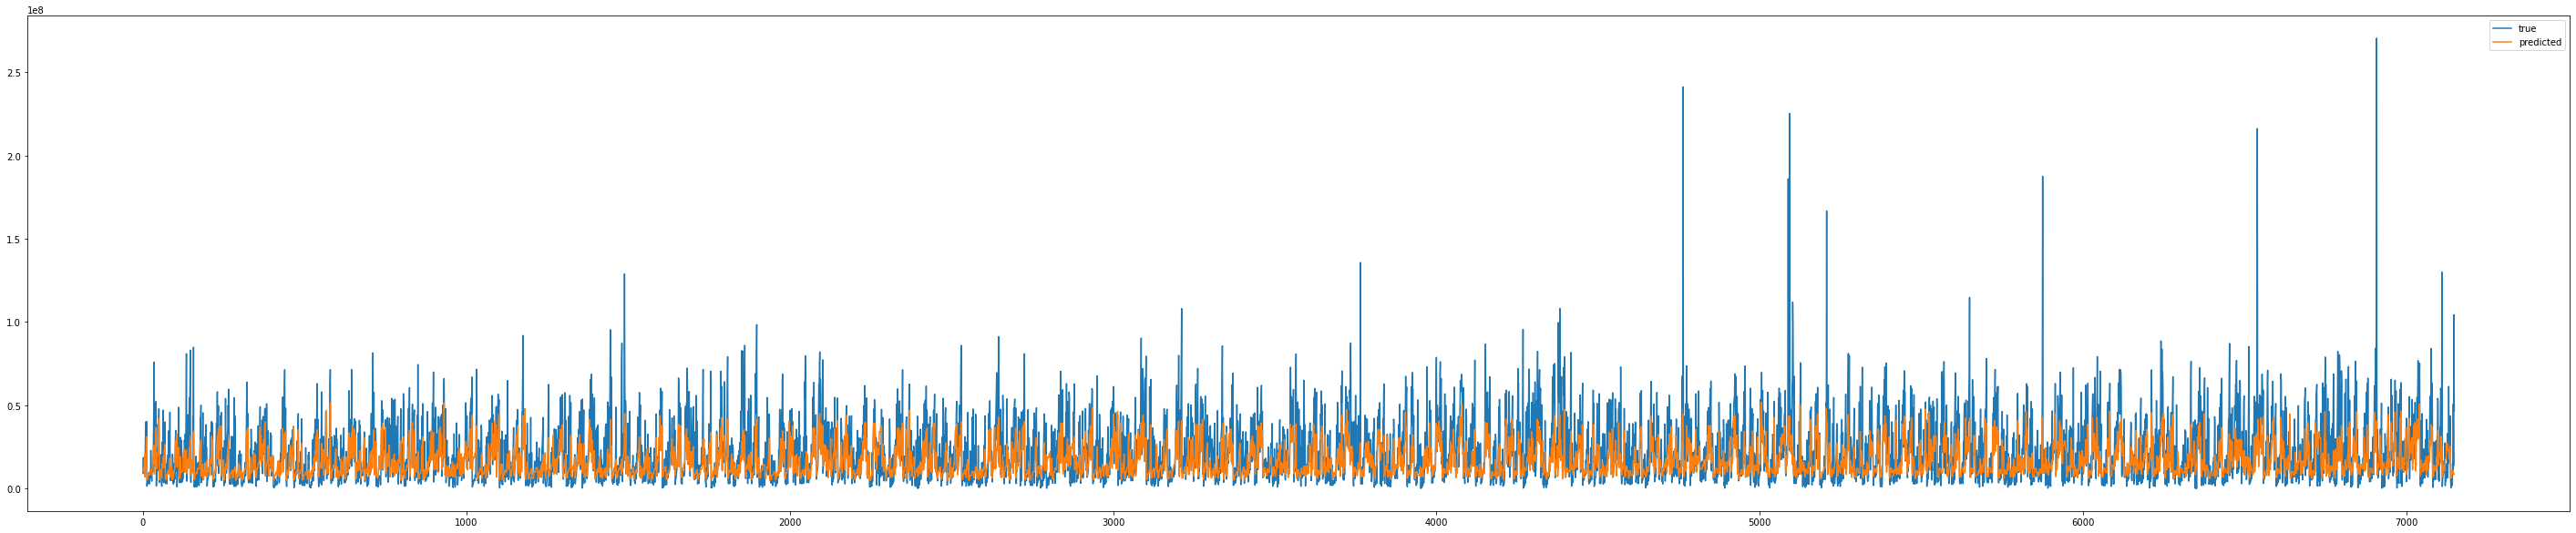

In [48]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11],
                     #max_depth = 10,
                                         )

#model_rmse = gbm.fit(train_x,train_y, eval_set=[(val_x, val_y)],verbose = 100, eval_metric = 'rmse', early_stopping_rounds = 100) ##100
model_mape = gbm1.fit(train1_x,train1_y, eval_set=[(val1_x, val1_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds1 = gbm1.predict(val1_x, num_iteration= model_mape.best_iteration_)
    
oof_preds1[oof_preds1 < 0] = 0

x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val1_y,label='true')
plt.plot(x,oof_preds1, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [49]:
neg_mape(val1_y, oof_preds1)

-80.78120005015296

In [50]:
def get_rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

In [51]:
get_rmse(val1_y, oof_preds1)

15186208.823221123

In [52]:
def get_mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [53]:
get_mae(val1_y, oof_preds1)

9893680.035367986

In [54]:
fi = {'name' : model_mape.feature_name_,
    'importance': model_mape.feature_importances_}
fi = pd.DataFrame(fi, columns = ['name','importance'])
fi.sort_values(by=['importance'], inplace=True, ascending = False)

In [55]:
fi.iloc[:30,:]

,name,importance
64,rolling_mean_mcode_14,5733
8,parttime,4048
9,small_c,3260
6,min_start,2688
70,ts_pred,2257
63,rolling_mean_mcode_7,2091
10,middle_c,1249
29,steady,1008
7,japp,1007
32,pay,585


# 7.

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.03263
[200]	valid_0's mape: 0.801555
[300]	valid_0's mape: 0.772316
[400]	valid_0's mape: 0.757256
[500]	valid_0's mape: 0.746951
[600]	valid_0's mape: 0.749174
[700]	valid_0's mape: 0.741572
[800]	valid_0's mape: 0.733512
[900]	valid_0's mape: 0.734264
[1000]	valid_0's mape: 0.734325
[1100]	valid_0's mape: 0.732847
[1200]	valid_0's mape: 0.73162
[1300]	valid_0's mape: 0.741193
[1400]	valid_0's mape: 0.748663
[1500]	valid_0's mape: 0.755583
[1600]	valid_0's mape: 0.767711
[1700]	valid_0's mape: 0.764435
[1800]	valid_0's mape: 0.765261
[1900]	valid_0's mape: 0.77512
[2000]	valid_0's mape: 0.77789
[2100]	valid_0's mape: 0.788476
[2200]	valid_0's mape: 0.794988
[2300]	valid_0's mape: 0.800161
[2400]	valid_0's mape: 0.814087
[250

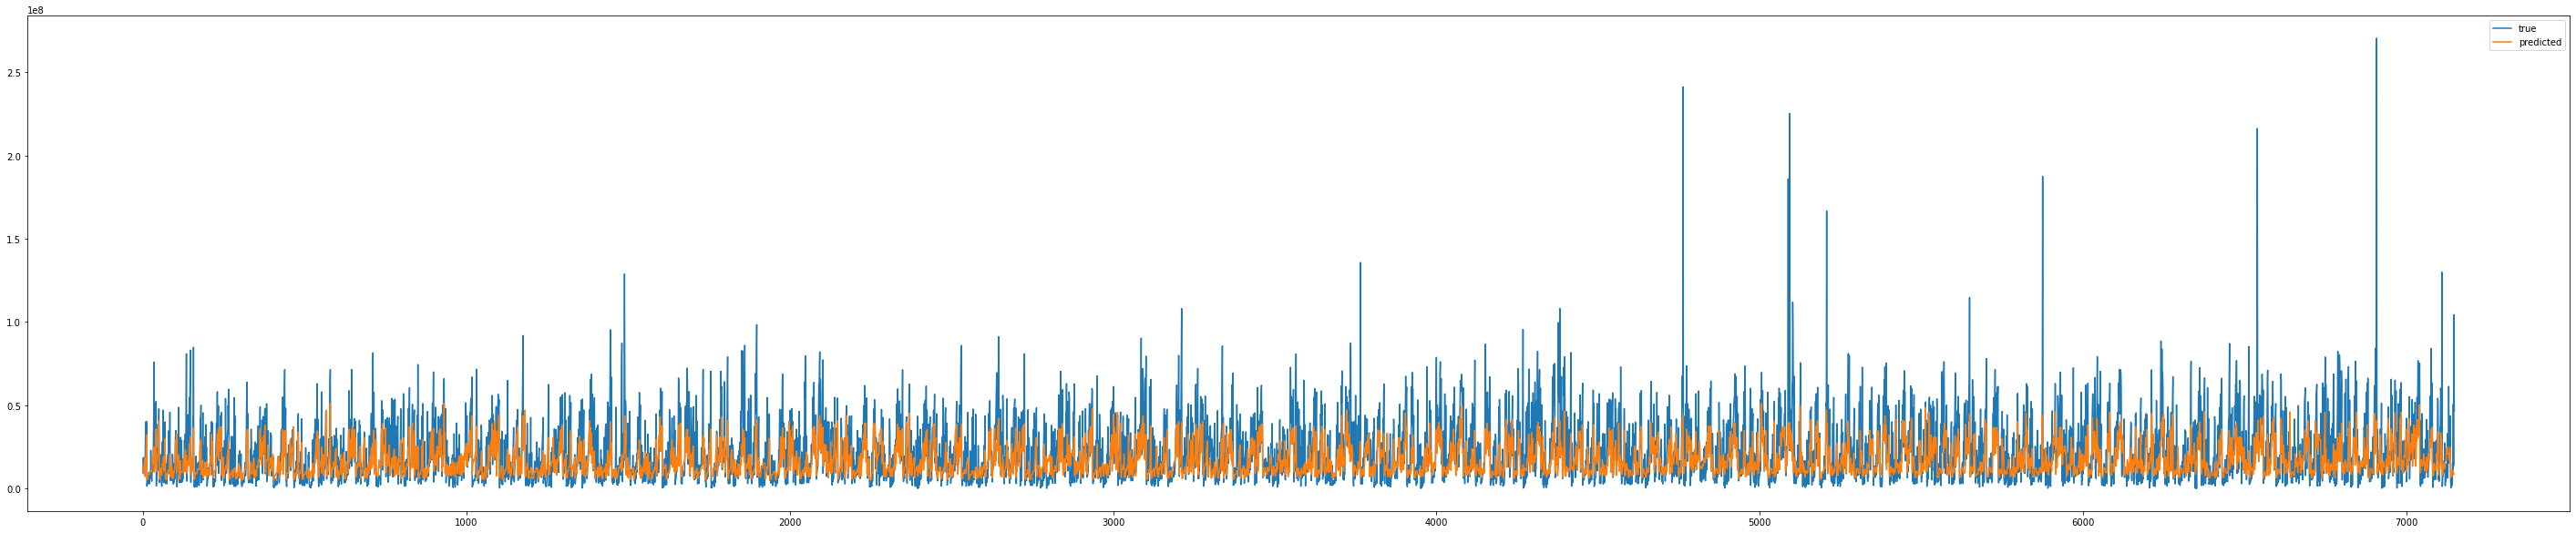

In [56]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10],
                     #max_depth = 10,
                                         )

#model_rmse = gbm.fit(train_x,train_y, eval_set=[(val_x, val_y)],verbose = 100, eval_metric = 'rmse', early_stopping_rounds = 100) ##100
model_mape = gbm1.fit(train7_x,train7_y, eval_set=[(val7_x, val7_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds7 = gbm1.predict(val7_x, num_iteration= model_mape.best_iteration_)
    
oof_preds7[oof_preds7 < 0] = 0

x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val7_y,label='true')
plt.plot(x,oof_preds7, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [57]:
get_rmse(val7_y, oof_preds7)

15054519.085749593

In [58]:
get_mae(val7_y, oof_preds7)

9834599.628000464

# 2.

In [60]:
train2_x.columns

Index(['상품군', '판매단가', 'months', 'weekdays', 'hours_inweek', 'weekends',
       'min_start', 'japp', 'parttime', 'small_c', 'middle_c', 'big_c',
       'primetime', 'prime_smallc', 'freq', 'dup_times', 'dup_times_smallc',
       'lag_scode_count', 'lag_mcode_price', 'lag_mcode_count',
       'lag_bigcat_price', 'lag_bigcat_count', 'lag_bigcat_price_day',
       'lag_bigcat_count_day', 'lag_small_c_price', 'lag_small_c_count',
       'lag_all_price_show', 'lag_all_price_day', 'bpower', 'steady', 'men',
       'luxury', 'pay', 'spring', 'summer', 'fall', 'winter', 'small_click_r',
       'mid_click_r', 'big_click_r', 'rain', 'temp_diff_s', 'exposed_t',
       'age30_small', 'age40_small', 'age50_small', 'age60above_small',
       'age30_middle', 'age40_middle', 'age50_middle', 'age60above_middle',
       'age30_big', 'age40_big', 'age50_big', 'age60above_big', 'pc_small',
       'mobile_small', 'pc_middle', 'mobile_middle', 'pc_big', 'mobile_big',
       'rolling_mean_7', 'rolling_mean_14

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[100]	valid_0's mape: 1.02952
[200]	valid_0's mape: 0.797454
[300]	valid_0's mape: 0.765091
[400]	valid_0's mape: 0.75054
[500]	valid_0's mape: 0.736467
[600]	valid_0's mape: 0.737209
[700]	valid_0's mape: 0.728373
[800]	valid_0's mape: 0.723094
[900]	valid_0's mape: 0.724348
[1000]	valid_0's mape: 0.726326
[1100]	valid_0's mape: 0.722514
[1200]	valid_0's mape: 0.719339
[1300]	valid_0's mape: 0.726434
[1400]	valid_0's mape: 0.732304
[1500]	valid_0's mape: 0.737912
[1600]	valid_0's mape: 0.748299
[1700]	valid_0's mape: 0.745465
[1800]	valid_0's mape: 0.746725
[1900]	valid_0's mape: 0.757022
[2000]	valid_0's mape: 0.759917
[2100]	valid_0's mape: 0.769711
[2200]	valid_0's mape: 0.775992
[2300]	valid_0's mape: 0.780232
[2400]	valid_0's mape: 0.793006
[2

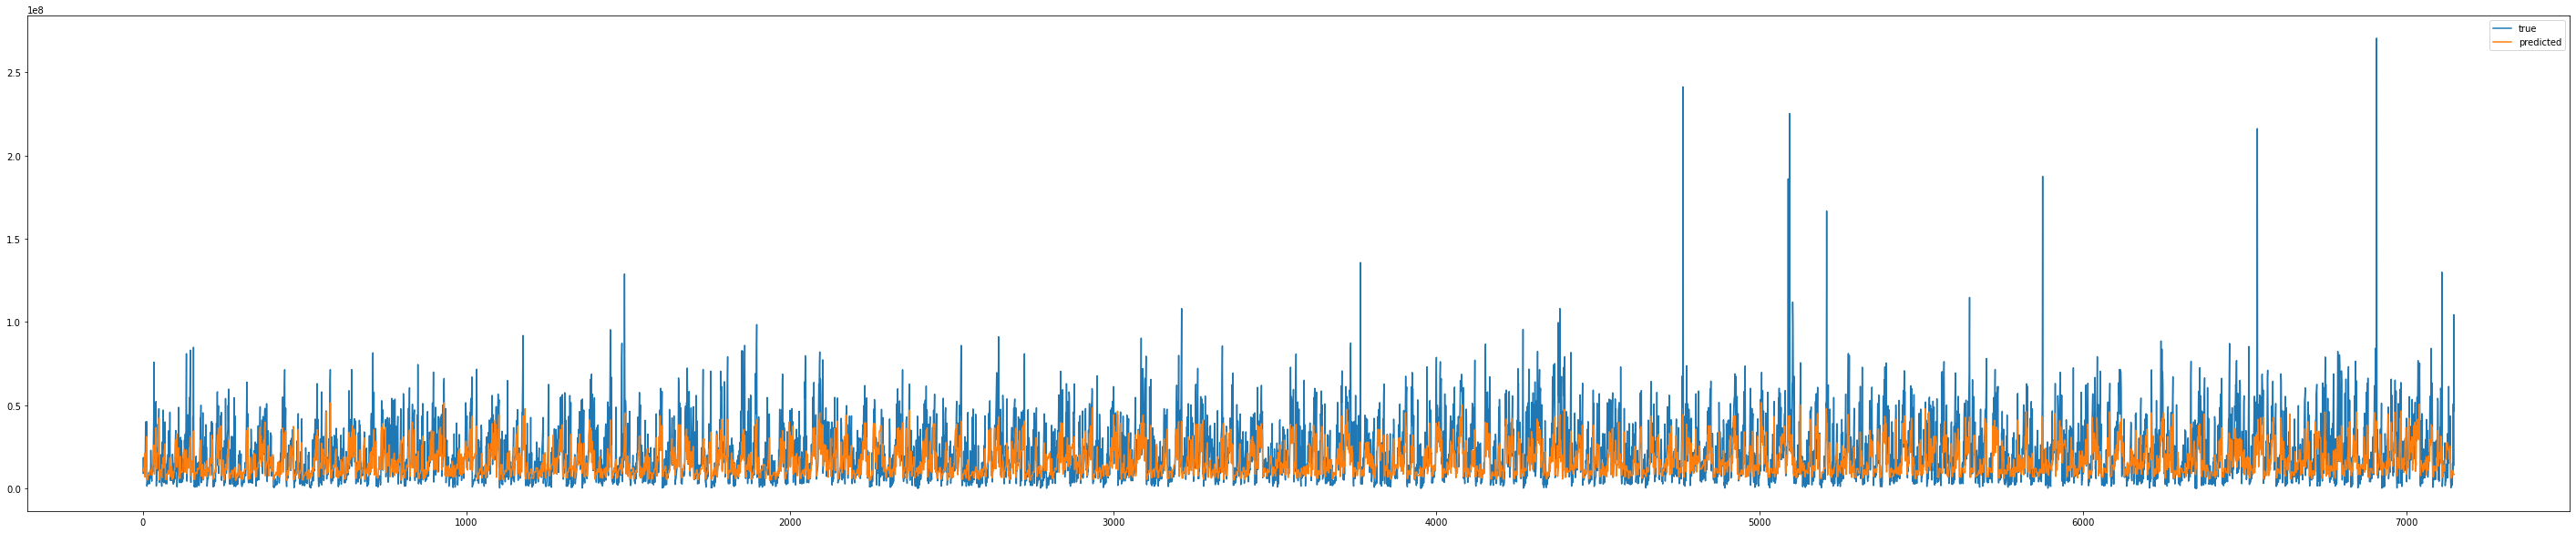

In [61]:
gbm1 = LGBMRegressor(objective = 'regression', 
                     boosting_type = 'dart', 
                     metric = 'mape',
                     n_estimators = 3000, #10000
                     num_leaves = 10, #10
                     learning_rate = 0.002, #0.01
                     bagging_fraction = 0.9,
                     feature_fraction = 0.5,
                     bagging_seed = 0,
                     categorical_feature = [0,9,10,11,3],
                     #max_depth = 10,
                                         )

#model_rmse = gbm.fit(train_x,train_y, eval_set=[(val_x, val_y)],verbose = 100, eval_metric = 'rmse', early_stopping_rounds = 100) ##100
model_mape = gbm1.fit(train2_x,train2_y, eval_set=[(val2_x, val2_y)],verbose = 100, 
                        eval_metric = 'mape', early_stopping_rounds = 100) ##100
oof_preds2 = gbm1.predict(val2_x, num_iteration= model_mape.best_iteration_)
    
oof_preds2[oof_preds2 < 0] = 0

x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val2_y,label='true')
plt.plot(x,oof_preds2, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [63]:
get_rmse(val7_y, oof_preds7)

15054519.085749593

In [64]:
get_mae(val7_y, oof_preds7)

9834599.628000464

In [65]:
neg_mape(val7_y, oof_preds7)

-82.58220865202942

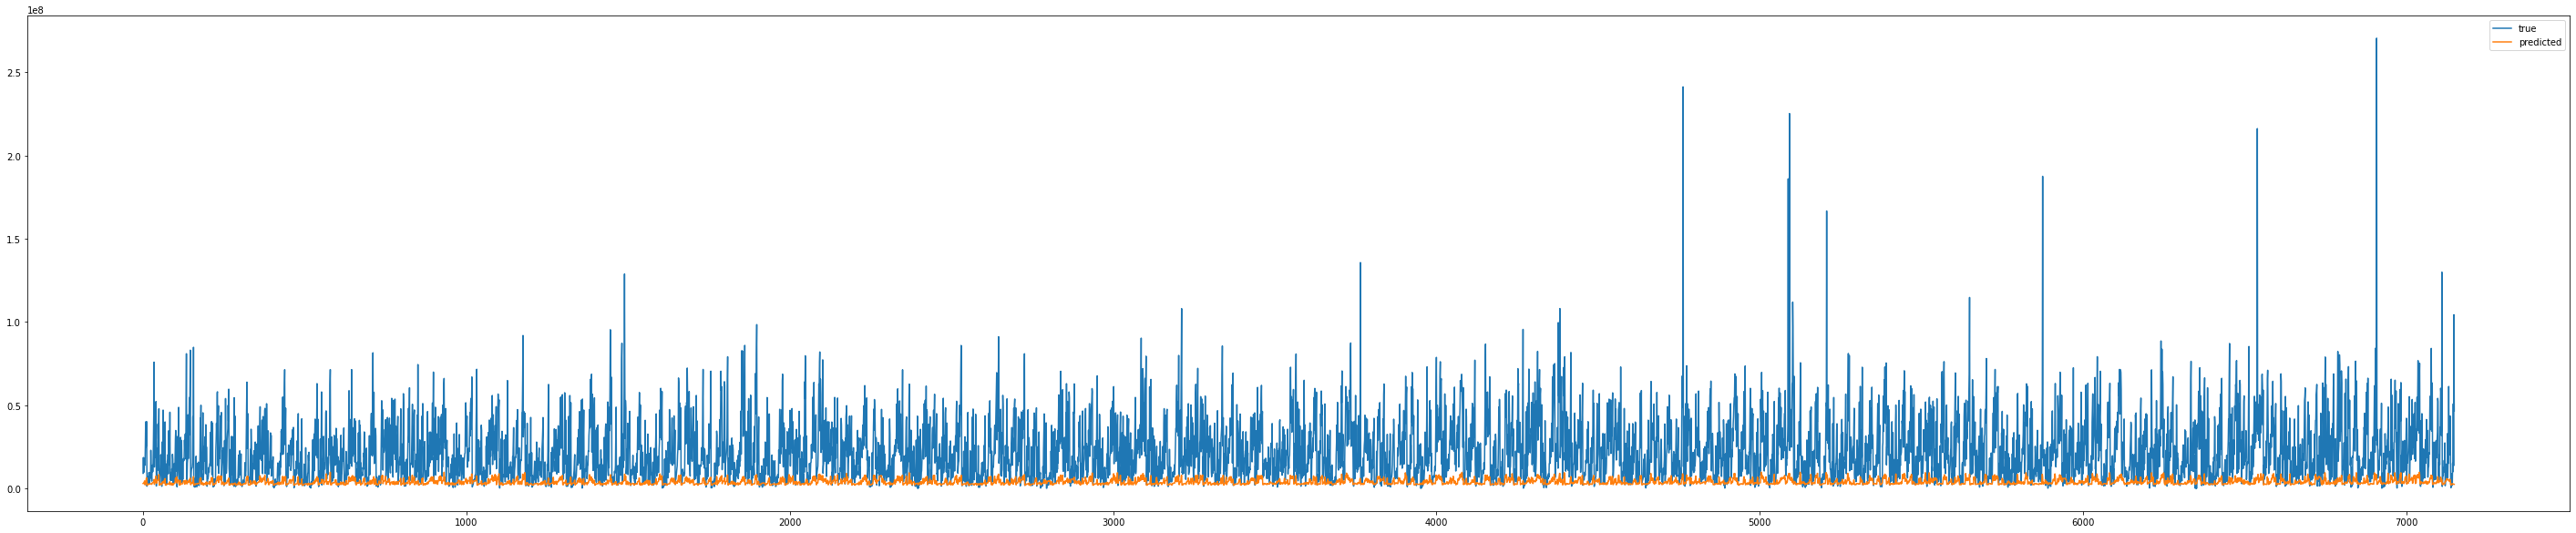

In [75]:
oof_preds22 = gbm1.predict(val2_x, num_iteration= 1200)
    
oof_preds22[oof_preds22 < 0] = 0

x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val2_y,label='true')
plt.plot(x,oof_preds22, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [77]:
get_mae(val2_y, oof_preds22)

18687500.488349415

In [78]:
neg_mape(val2_y, oof_preds22)

-74.5596684126452

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
rf = RandomForestRegressor(n_estimators = 1000, n_jobs = -1,oob_score = True,bootstrap = True,random_state = 42)
rf.fit(train5_x,train5_y)

#print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
      

RandomForestRegressor(n_estimators=1000, n_jobs=-1, oob_score=True,
                      random_state=42)

In [68]:
y_pred_rf = rf.predict(val5_x)
def neg_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    result = (-1)*mape
    return result
neg_mape(val5_y, y_pred_rf)

-163.46446282181182

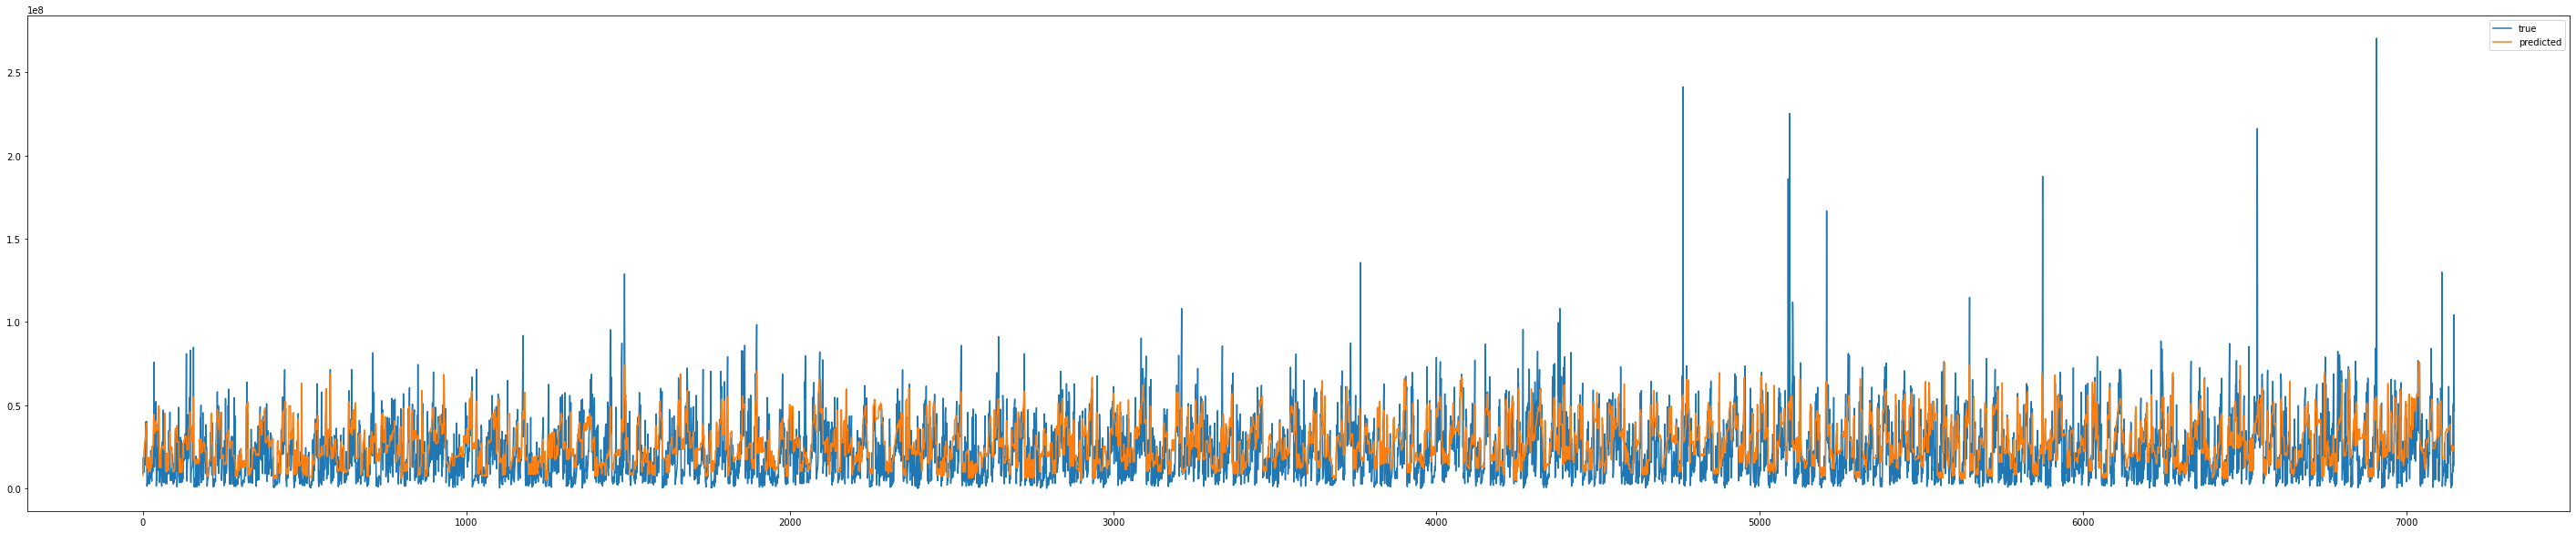

In [69]:
x = range(0,7149)
plt.figure(figsize=(50,10))
plt.plot(x,val5_y,label='true')
plt.plot(x,y_pred_rf, label='predicted')

# call with no parameters
plt.legend()

plt.show()

In [72]:
get_rmse(val5_y, y_pred_rf)

15494606.21627426

In [73]:
get_mae(val5_y, y_pred_rf)

11584495.567491956

In [79]:
neg_mape(val5_y, y_pred_rf)

-163.46446282181182

# LSTM

# No lag

In [87]:
from sklearn.preprocessing import RobustScaler
num_col = ['취급액','판매단가','lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',  'lag_bigcat_price_day',
           'lag_bigcat_count_day',  'lag_small_c_price', 'lag_small_c_count', 'lag_all_price_show', 'lag_all_price_day', 'mid_click_r',
            'big_click_r', 'temp_diff_s', 'age30_small', 'age40_small', 'age50_small', 'age60above_small', 'age30_middle', 'age40_middle',
            'age50_middle', 'age60above_middle', 'age30_big', 'age40_big', 'age50_big', 'age60above_big', 'pc_small', 'mobile_small',
            'pc_middle', 'mobile_middle', 'pc_big', 'mobile_big', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_mcode_7', 'rolling_mean_mcode_14',
            'lag_sales_wd_1', 'lag_sales_wd_2', 'lag_sales_wd_3', 'lag_sales_wd_4', 'lag_sales_wd_5', 'ts_pred']


df_wd_no_lag_lstm = df_wd_no_lag_PP.copy()
xcol = [x for x in df_wd_no_lag_lstm.columns if x in num_col]

## Normalization
scaler = RobustScaler()
for i in xcol:
    df_wd_no_lag_lstm[i] = scaler.fit_transform(df_wd_no_lag_lstm[i].values.reshape(-1,1))

train8_x = df_wd_no_lag_lstm.iloc[:16904,:].drop(columns = ['index','show_id','취급액','small_c'])
train8_y = df_wd_no_lag_lstm.iloc[:16904,3]
val8_x = df_wd_no_lag_lstm.iloc[16904:,:].drop(columns = ['index','show_id','취급액','small_c'])
val8_y = df_wd_no_lag_lstm.iloc[16904:,3]

train_x = train8_x.values.reshape((train8_x.shape[0], 1, train8_x.shape[1]))
val_x = val8_x.values.reshape((val8_x.shape[0], 1, val8_x.shape[1]))
train_y = train8_y.values
val_y = val8_y.values

print(train_x.shape, val_x.shape,
      train_y.shape, val_y.shape)

(16904, 1, 66) (7150, 1, 66) (16904,) (7150,)


# Lag , drop small_c

In [92]:
df_wd_lag_lstm = df_wd_lag_PP.copy()
xcol = [x for x in df_wd_lag_lstm.columns if x in num_col]

## Normalization
scaler = RobustScaler()
for i in xcol:
    df_wd_lag_lstm[i] = scaler.fit_transform(df_wd_lag_lstm[i].values.reshape(-1,1))

train8_x = df_wd_lag_lstm.iloc[:16904,:].drop(columns = ['index','show_id','취급액','small_c'])
train8_y = df_wd_lag_lstm.iloc[:16904,:].취급액
val8_x = df_wd_lag_lstm.iloc[16904:,:].drop(columns = ['index','show_id','취급액','small_c'])
val8_y = df_wd_lag_lstm.iloc[16904:,:].취급액

train_x = train8_x.values.reshape((train8_x.shape[0], 1, train8_x.shape[1]))
val_x = val8_x.values.reshape((val8_x.shape[0], 1, val8_x.shape[1]))
train_y = train8_y.values
val_y = val8_y.values

print(train_x.shape, val_x.shape,
      train_y.shape, val_y.shape)

(16904, 1, 75) (7149, 1, 75) (16904,) (7149,)


In [2]:
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras import optimizers
from keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'keras'

In [3]:
import tensorflow as tf

ImportError: cannot import name 'export_saved_model' from 'tensorflow.python.keras.saving.saved_model' (/Users/yeojin/anaconda3/envs/yjenv/lib/python3.7/site-packages/tensorflow/python/keras/saving/saved_model/__init__.py)

In [ ]:
# Setting parameters for model and begin training
epoch = 1500
batch = 256
decay = 0 
learning_rate = 0.003
neurons = 17
dropout = 0.1
output_neurons = 1
version = 0

# Model architecture
model = Sequential()
model.add(LSTM(neurons, input_shape=(1, train_x.shape[2]), return_sequences=False, name='L1'))

# We could add dropout in layers if model overfits.
model.add(Dropout(dropout,  name='Dro1'))  
model.add(Dense(output_neurons, name='De1'))
# We could add activation function for better learning of model.
# model.add(Activation('relu'))
adam = optimizers.Adam(lr=learning_rate, decay=decay)
model.compile(loss='mean_squared_error', optimizer=adam)

# Using checkpoint to save only 1 model that fits best on validation data.
file_path = "./SimpleLSTM_rmse" \
            + "a.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(train_x, train_y, batch_size=batch, epochs=epoch, validation_data=(val_x, y_val), verbose=2, callbacks=[checkpoint])